## Importações

In [38]:
%matplotlib inline

import sys
import lumapi
import os
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.constants import c


In [39]:
inter = lumapi.INTERCONNECT()

In [40]:
um = 1e-6
nm = 1e-9

Lr = np.array([553.97536458,  55.39753646,  27.69876823])

raio = 5*um
comprimentos_guias = Lr*1e-6 - 4*np.pi*raio
print(raio)
print(comprimentos_guias/2)

4.9999999999999996e-06
[ 2.45571756e-04 -3.71715831e-06 -1.75665424e-05]


## Criação e posicionamento dos blocos

In [ ]:

inter.switchtodesign()
inter.deleteall()

inter.addelement('Optical Network Analyzer')
inter.set("number of points",50000)
inter.set("number of input ports",2)
inter.set("input parameter",2)
inter.set("start frequency", c/(1500*nm))
inter.set("stop frequency", c/(1600*nm))

# 1 - ideal
# 2 - real
# 3 - pdk
caso = 1

#indice[0] 1um
#indice[1] 10um
#indice[2] 20um

comprimentos_guias_ideal = Lr[1]/2

if (caso == 1):
    inter.addelement('Waveguide Coupler')
    inter.set("name", "DC1")

    inter.select("DC1")
    inter.copy()
    inter.set("name","DC2")

    inter.addelement('Straight waveguide')
    inter.set("name", "Guia_1")
    inter.set("length",comprimentos_guias_ideal*um)
    inter.set("effective index 1", 2.35400)
    inter.set("group index 1", 4.33683)
    inter.rotateelement("Guia_1")

    inter.select("Guia_1")
    inter.copy()
    inter.set("name","Guia_2")

elif (caso == 2):
    inter.addelement("Optical N Port S-Parameter")
    inter.set("name", "Y1")
    inter.set("load from file", 1)
    inter.set("s parameters filename", r"C:\Users\gson5\Downloads\ERICK TRALHAS\FOTÔNICA\LAB. 7\te.dat")

    inter.select("Y1")
    inter.copy()
    inter.set("name","Y2")
    inter.rotateelement("Y2")
    inter.rotateelement("Y2")

    inter.addelement("MODE Waveguide")
    inter.set("name", "Guia_1")
    inter.set("ldf filename", r"C:\Users\gson5\Downloads\ERICK TRALHAS\FOTÔNICA\LAB. 10 - MZI\GUIA.ldf")
    inter.set("length", guia_menor + delta_L*um)

    inter.select("Guia_1")
    inter.copy()
    inter.set("name","Guia_2")
    inter.set("length", guia_menor)
elif (caso == 3):
    inter.expressioncheckoff()
    inter.addelement("ebeam_dc_te1550")
    inter.set("name", "DC1")

    inter.select("DC1")
    inter.copy()
    inter.set("name","DC2")
    inter.rotateelement("DC2")
    inter.rotateelement("DC2")

    inter.addelement('ebeam_wg_integral_1550')
    inter.set("name", "Guia_1")
    inter.set("annotate", False)
    inter.set("wg_length", comprimentos_guias)
    inter.set("wg_width", 450e-9)

    inter.addelement('ebeam_wg_integral_1550')
    inter.set("name", "Guia_2")
    inter.set("annotate", False)
    inter.set("wg_length", comprimentos_guias)
    inter.set("wg_width", 450e-9)

inter.setposition("ONA_1",-220,-270)
inter.setposition("DC1",0,175)
inter.setposition("DC2",0,175*3)
inter.setposition("Guia_1",220,175*2)
inter.setposition("Guia_2",-220,175*2)


## Conexão dos blocos

In [42]:
if(caso == 1):
    inter.connect("DC1", "port 4", "Guia_1", "port 1")
    inter.connect("DC1", "port 2", "Guia_2", "port 1")
    inter.connect("Guia_1", "port 2", "DC2", "port 3")
    inter.connect("Guia_2", "port 2", "DC2", "port 1")
    inter.connect("ONA_1", "output", "DC2", "port 2")
    inter.connect("ONA_1", "input 1", "DC2", "port 4")
    inter.connect("ONA_1", "input 2", "DC1", "port 1")

elif(caso == 2):
    inter.connect("Y1", "out 1", "Guia_1", "port 1")
    inter.connect("Y1", "out 2", "Guia_2", "port 1")
    inter.connect("Guia_1", "port 2", "Y2", "out 2")
    inter.connect("Guia_2", "port 2", "Y2", "out 1")
    inter.connect("ONA_1", "output", "Y1", "in")
    inter.connect("ONA_1", "input 1", "Y2", "in")
elif(caso == 3):
    inter.connect("Y1", "opt_b1", "Guia_1", "port 1")
    inter.connect("Y1", "opt_b2", "Guia_2", "port 1")
    inter.connect("Guia_1", "port 2", "Y2", "opt_b2")
    inter.connect("Guia_2", "port 2", "Y2", "opt_b1")
    inter.connect("ONA_1", "output", "Y1", "opt_a1")
    inter.connect("ONA_1", "input 1", "Y2", "opt_a1")    

In [43]:
inter.run()

## Obtenção de resultados

In [44]:
if (caso == 1):
    TE_gain_1 = np.squeeze(inter.getresult("ONA_1","input 1/mode 1/gain")['TE gain (dB)'])
    TE_gain_2 = np.squeeze(inter.getresult("ONA_1","input 2/mode 1/gain")['TE gain (dB)'])
    
    FSR1 = inter.getresult("ONA_1","input 1/mode 1/peak/free spectral range")
    fsr_wv1= np.squeeze(FSR1['wavelength'])
    FSR1 = FSR1["TE free spectral range (m)"]

    FSR2 = inter.getresult("ONA_1","input 2/mode 1/peak/free spectral range")
    fsr_wv2= np.squeeze(FSR2['wavelength'])
    FSR2 = FSR2["TE free spectral range (m)"]

elif (caso == 2):
    TE_gain = np.squeeze(inter.getresult("ONA_1","input 1/mode 1/gain")['mode 1 gain (dB)'])
    FSR1 = inter.getresult("ONA_1","input 1/mode 1/peak/free spectral range")
    fsr_wv= np.squeeze(FSR1['wavelength'])
    FSR1 = FSR1["mode 1 free spectral range (m)"]
    
elif (caso == 3):
    TE_gain = np.squeeze(inter.getresult("ONA_1","input 1/mode 1/gain")["'TE' gain (dB)"])
    FSR1 = inter.getresult("ONA_1","input 1/mode 1/peak/free spectral range")
    fsr_wv= np.squeeze(FSR1['wavelength'])
    FSR1 = FSR1["'TE' free spectral range (m)"]

comprimentos_de_onda1 = np.squeeze(inter.getresult("ONA_1","input 1/mode 1/gain")['wavelength'])
comprimentos_de_onda2 = np.squeeze(inter.getresult("ONA_1","input 2/mode 1/gain")['wavelength'])

<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
C:\Users\gson5\AppData\Local\Temp\ipykernel_12020\1876898179.py:6: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('Comprimento de Onda $(\mu m)$', fontsize = 16)


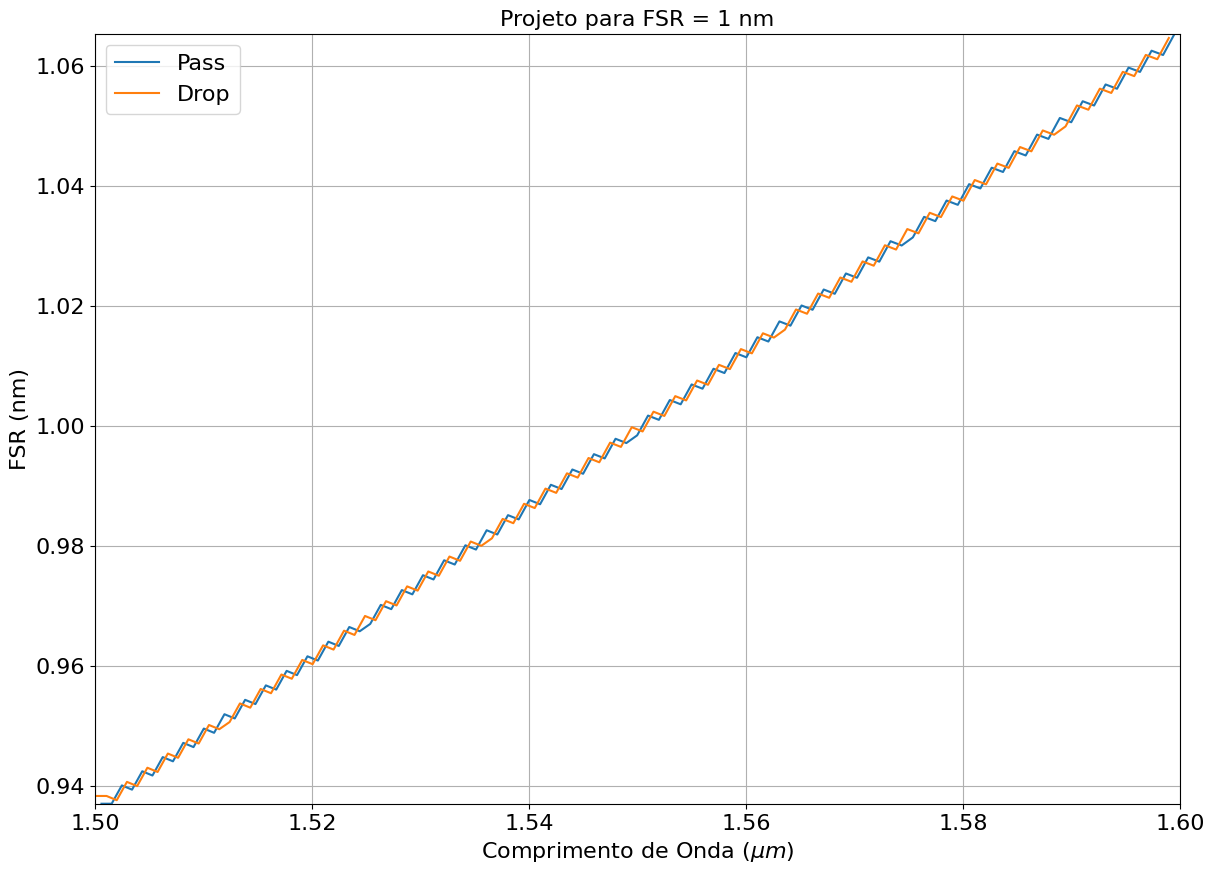

In [52]:
plt.figure(figsize=(14,10))

plt.plot(fsr_wv1*1e6,FSR1*1e9, label = "Pass")
plt.plot(fsr_wv2*1e6,FSR2*1e9, label = "Drop")

plt.xlabel('Comprimento de Onda $(\mu m)$', fontsize = 16)
plt.ylabel('FSR (nm)', fontsize = 16)
plt.title("Projeto para FSR = 1 nm", fontsize = 16)

plt.tick_params(axis='both', labelsize=16)

plt.xlim(1.5,1.6)
plt.ylim(min(FSR1*1e9) ,max(FSR1*1e9))

plt.legend(loc = "best", fontsize = 16)

plt.grid(True)

plt.savefig('C:/Users/gson5/Downloads/GIT/Photonics-API-lumapi/LAB. 11 - RING/RESULTADOS/FSR 1nm IDEAL.png')
plt.show()

<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
C:\Users\gson5\AppData\Local\Temp\ipykernel_12020\3379654591.py:5: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('Comprimento de Onda $(\mu m)$', fontsize = 16)


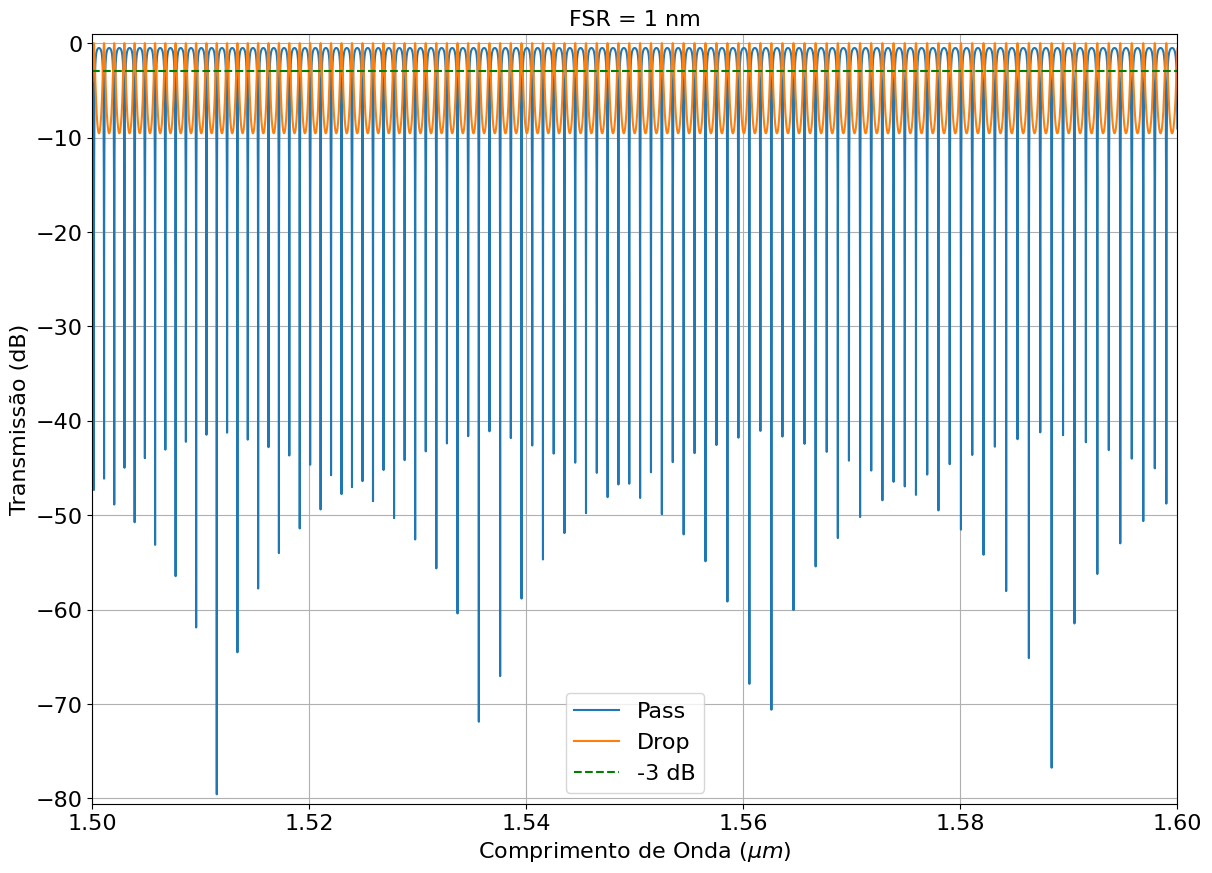

In [53]:

plt.figure(figsize=(14,10))

plt.plot(comprimentos_de_onda1*1e6,TE_gain_1, label = "Pass")
plt.plot(comprimentos_de_onda2*1e6,TE_gain_2, label = "Drop")
plt.xlabel('Comprimento de Onda $(\mu m)$', fontsize = 16)
plt.ylabel('Transmissão (dB)', fontsize = 16)
plt.title('FSR = 1 nm', fontsize = 16)

plt.axhline(y=-3, linestyle='--', color ="g",label = '-3 dB')

plt.tick_params(axis='both', labelsize=16)

plt.xlim(1.5,1.6)
plt.ylim(min(TE_gain_1) - 1 ,1)

plt.legend(loc = "best", fontsize = 16)

plt.grid(True)

plt.savefig('C:/Users/gson5/Downloads/GIT/Photonics-API-lumapi/LAB. 11 - RING/RESULTADOS/TRANSMISSÃO FSR 1nm IDEAL.png')
plt.show()


In [47]:
##inter.close()